# KGRAG Ex demo

This notebook demonstrates KGRAG Ex bulit with Statpearl as Context and tested on MedMCQA, a medical multiple-choice dataset.

Workflow:
1. Load Statpearls
2. Build KG from 300 documents (they get chunked so 13922 chunks or docs) from Statpearl
3. Few insights about the KG
4. Syntetic Test based on found path in the insights section
5. Load MedMCQA plus filtering the question where we have some kontext (59) plus only use questions where there is a directed path in the kg (12)
7. Single run test on first MedMQCA question
8. Find the corresponding chunk for the important node, edge and subpaths
9. run the experiment on all 12 questions



## Notebook setup and project path

Ensure the project root is on `sys.path` so local modules import correctly.


In [2]:
import sys
from pathlib import Path

project_root = next((p for p in [Path.cwd()] + list(Path.cwd().parents) if (p / "src").exists()), None)
if project_root is None:
    raise RuntimeError('"src" Verzeichnis nicht gefunden. Bitte Notebook im Projekt laufen lassen.')

root_str = str(project_root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

print("Project root:", project_root)


Project root: /Users/MeinNotebook/xai-rag


## Imports

Load data loaders, RAG components, KG builders, and the KGRAG Ex pipeline.


In [14]:
from pathlib import Path
import json
import networkx as nx
import numpy as np
from collections import Counter
from typing import Any, Tuple, List, Dict, Optional, Tuple
from dataclasses import asdict, is_dataclass
import re

from src.modules.loader.statspearls_data_loader import StatPearlsDataLoader
from src.modules.loader.medmcqa_data_loader import MedMCQADataLoader

from src.modules.llm.llm_client import LLMClient

from src.modules.knowledge_graph.kg_triplet_extractor import KGTripletExtractor
from src.modules.knowledge_graph.kg_build_service import KGBuildService

from src.modules.knowledge_graph.kgrag_ex_pipeline import KGRAGExPipeline, KGStep
from src.modules.explainers.kgrag_ex_explainer import KGRAGExExplainer
from src.modules.knowledge_graph.relation_registry import RelationRegistry, ProposedRelation, canon_relation

from langchain_core.documents import Document

## 1. Load StatPearls

In [4]:
sp_loader = StatPearlsDataLoader()

statpearls_docs, sp_stats = sp_loader.setup(
    limit_articles=300,
    as_documents=True,
    force_download=False,
    force_extract=False,
    force_rebuild_jsonl=False,
)

print("StatPearls stats:", sp_stats)
print("Docs:", len(statpearls_docs))
print("Sample meta:", statpearls_docs[0].metadata)
print("Sample preview:", statpearls_docs[0].page_content[:200])

StatPearls stats: StatPearlsBuildStats(tarball_downloaded=False, extracted=False, nxml_files_found=9629, jsonl_files_created=0, articles_loaded=300, chunks_emitted=13922)
Docs: 13922
Sample meta: {'source': 'statpearls', 'split': 'repo', 'title': 'Thrombolysis in Myocardial Infarction (TIMI) Trial, Phase I: A comparison between intravenous tissue plasminogen activator and intravenous streptokinase. Clinical findings through hospital discharge.', 'topic_name': 'Thrombolysis in Myocardial Infarction (TIMI) Trial, Phase I: A comparison between intravenous tissue plasminogen activator and intravenous streptokinase. Clinical findings through hospital discharge.', 'source_filename': 'article-100024.nxml', 'chunk_index': 0, 'chunk_id': '6de0970aebeb1d82231d62346489c3cd6ee24eebe32979badfdeae7817d4c9bb'}
Sample preview: Thrombolysis in Myocardial Infarction (TIMI) Trial, Phase I: A comparison between intravenous tissue plasminogen activator and intravenous streptokinase. Clinical findings throu

## 2. LLM client
### ollama need to be started before instanciating the client

In [7]:
client = LLMClient(provider="ollama", model_name="gemma3:4b")

## 3. Build the KG from StatPearls chunks with an dynamically growing relation registry

In [8]:
registry_path = Path("../data/relations_registry.json")
registry = RelationRegistry.load(registry_path)

extractor = KGTripletExtractor(llm_client=client, max_retries=2, relation_registry=registry)
kg_service = KGBuildService(extractor=extractor, relation_registry=registry, registry_cache_path=registry_path, add_reverse_edges=False)


kg_store, kg_stats = kg_service.build_or_load(
    docs=statpearls_docs,
    cache_path=Path("../data/statpearls_kg/kg_statpearls.jsonl"),
    limit=5000,
    force_rebuild=False,
    chunk_id_prefix="sp",
    source_name="statpearls",
)

## 4. Some KG stats


In [9]:
G = kg_store.g

n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

rel_edge_counts = Counter()
subject_counts = Counter()
object_counts = Counter()
subject_type_counts = Counter()
object_type_counts = Counter()

for u, v, _, data in G.edges(keys=True, data=True):
    rel = str(data.get("relation", "Unknown") or "Unknown")
    rel_edge_counts[rel] += 1

    subject_counts[u] += 1
    object_counts[v] += 1

    st = (data.get("subject_type") or G.nodes[u].get("type") or G.nodes[u].get("entity_type") or "Unknown")
    ot = (data.get("object_type") or G.nodes[v].get("type") or G.nodes[v].get("entity_type") or "Unknown")

    subject_type_counts[str(st)] += 1
    object_type_counts[str(ot)] += 1

wcc = list(nx.weakly_connected_components(G)) if n_nodes else []
largest_component = max((len(c) for c in wcc), default=0)

Gu = nx.Graph()
Gu.add_nodes_from(G.nodes())
Gu.add_edges_from((u, v) for u, v in G.edges())
neighbor_counts = np.array([d for _, d in Gu.degree()]) if n_nodes else np.array([0])

print(f"KG Entities (Nodes): {n_nodes}")
print(f"KG Relationen Links (aggregierte Kanten): {n_edges}")
print(f"Entity Cluster (weakly connected components): {len(wcc)}, größtes Cluster: {largest_component}")

print(
    "Entity Nachbarschaft (unique neighbors) min, median, mean, max:",
    int(neighbor_counts.min()),
    float(np.median(neighbor_counts)),
    float(neighbor_counts.mean()),
    int(neighbor_counts.max()),
)

print("Top Relationen nach aggregierten Links:", rel_edge_counts.most_common(12))
print("Most common Subjects:", subject_counts.most_common(12))
print("Most common Objects:", object_counts.most_common(12))
print("Most common Subject Types:", subject_type_counts.most_common(12))
print("Most common Object Types:", object_type_counts.most_common(12))


KG Entities (Nodes): 5716
KG Relationen Links (aggregierte Kanten): 6561
Entity Cluster (weakly connected components): 643, größtes Cluster: 4032
Entity Nachbarschaft (unique neighbors) min, median, mean, max: 1 1.0 2.1497550734779565 98
Top Relationen nach aggregierten Links: [('ASSOCIATED_WITH', 853), ('CAUSES', 275), ('CONTRAINDICATED_FOR', 173), ('TREATED_WITH', 159), ('AFFECTS', 156), ('INCLUDES', 136), ('CONTRIBUTES_TO', 123), ('USED_FOR', 111), ('TREATS', 109), ('REQUIRES', 85), ('CAN_CAUSE', 83), ('INDICATED_FOR', 79)]
Most common Subjects: [('Carvedilol', 98), ('patient', 95), ('nebivolol', 95), ('MET', 75), ('Epithelial downgrowth', 69), ('OMT', 63), ('Dyspareunia', 61), ('Cefotaxime', 56), ('Trisomy 13', 54), ('physician', 54), ('Iron deficiency', 52), ('Blepharospasm', 52)]
Most common Objects: [('Pain', 45), ('patient', 45), ('somatic dysfunction', 38), ('low back pain', 34), ('patients', 31), ('Iron deficiency', 31), ('Epithelial downgrowth', 30), ('Cardiopulmonary arrest

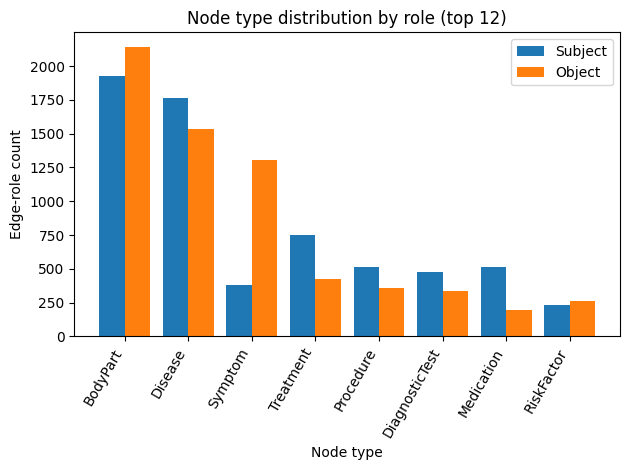

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def subject_object_type_counts(G):
    """
    Counts node types separately for subject and object roles based on edges.
    Uses node attribute 'type' as the semantic label.
    """
    subj = Counter()
    obj = Counter()

    for u, v, _, data in G.edges(keys=True, data=True):
        st = str(G.nodes[u].get("type", "Unknown"))
        ot = str(G.nodes[v].get("type", "Unknown"))
        subj[st] += 1
        obj[ot] += 1

    return subj, obj


def plot_subject_object_types_side_by_side(subj: Counter, obj: Counter, top_k: int = 12):
    """
    Paper-friendly: single figure with two bar charts (subject vs object),
    sharing the same type ordering (based on total counts).
    """
    total = subj + obj
    types = [t for t, _ in total.most_common(top_k)]

    subj_vals = [subj.get(t, 0) for t in types]
    obj_vals = [obj.get(t, 0) for t in types]

    x = np.arange(len(types))

    plt.figure()
    plt.bar(x - 0.2, subj_vals, width=0.4, label="Subject")
    plt.bar(x + 0.2, obj_vals, width=0.4, label="Object")
    plt.xticks(x, types, rotation=60, ha="right")
    plt.xlabel("Node type")
    plt.ylabel("Edge-role count")
    plt.title(f"Node type distribution by role (top {top_k})")
    plt.legend()
    plt.tight_layout()
    plt.show()


subj_types, obj_types = subject_object_type_counts(G)
plot_subject_object_types_side_by_side(subj_types, obj_types, top_k=12)


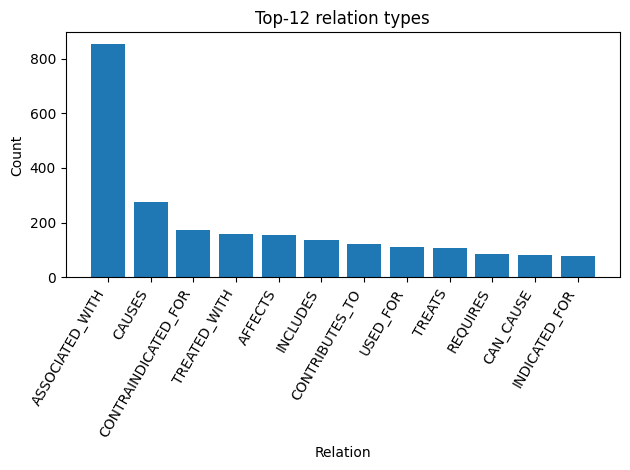

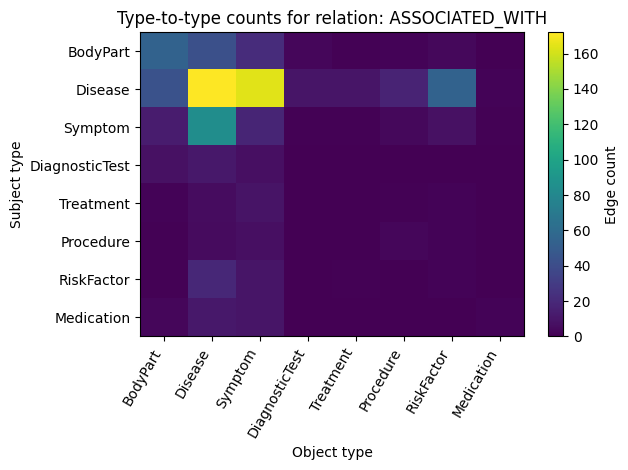

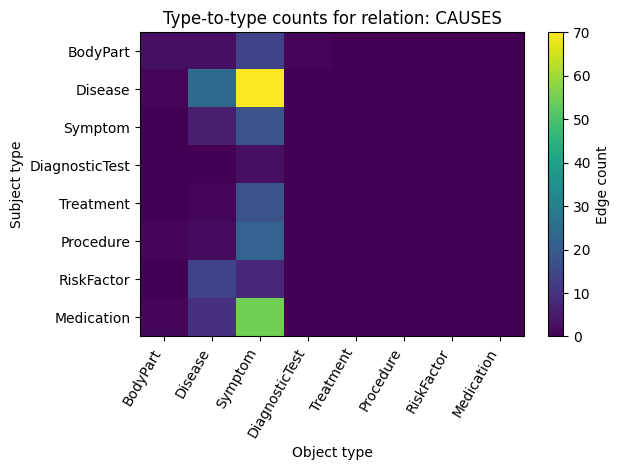

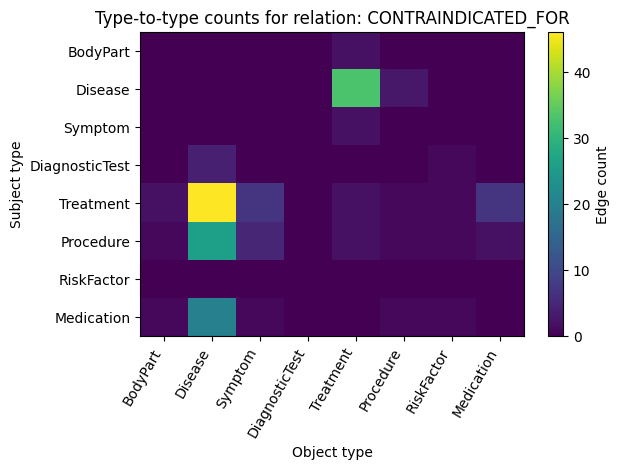

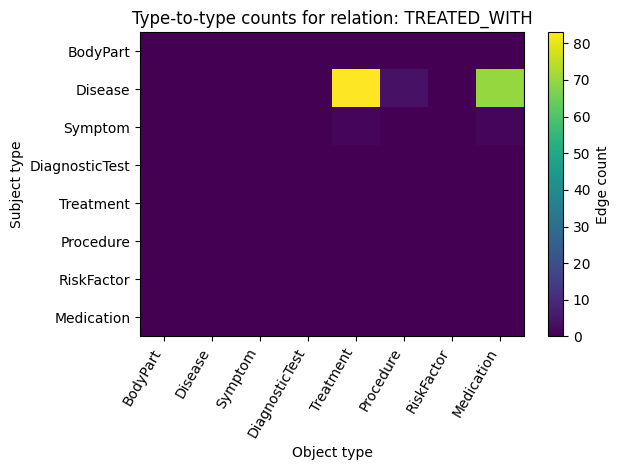

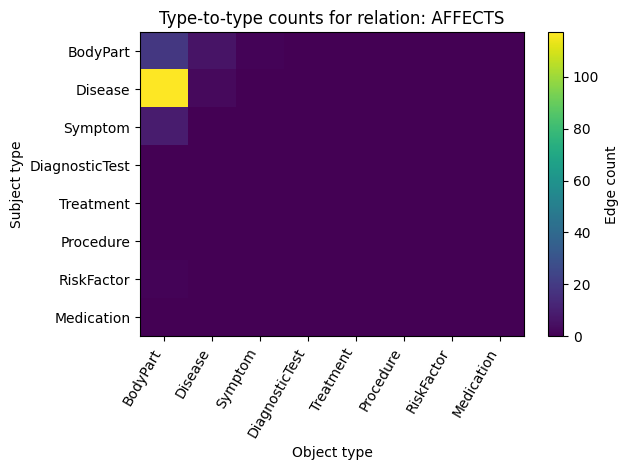

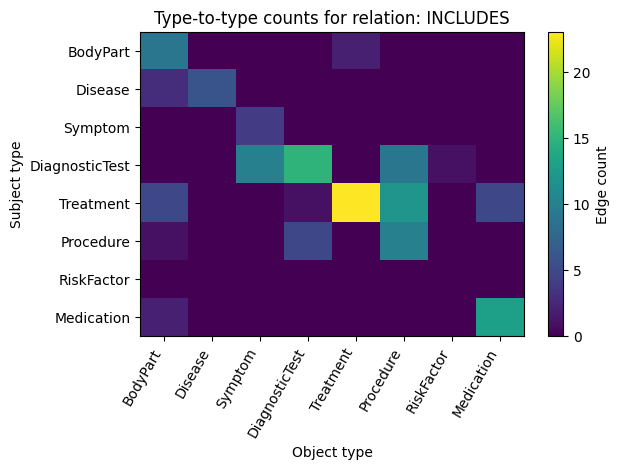

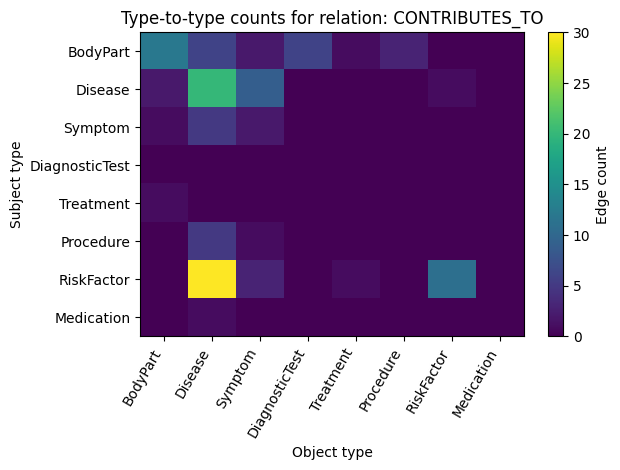

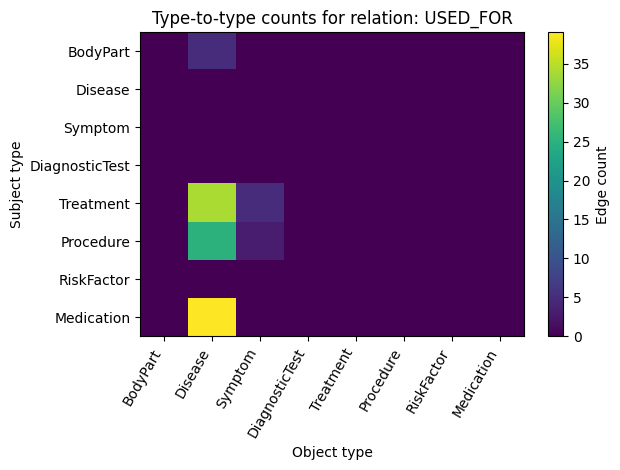

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

def kg_basic_counters(G):
    rel_edge_counts = Counter()
    for u, v, _, data in G.edges(keys=True, data=True):
        rel = str(data.get("relation", "Unknown") or "Unknown")
        rel_edge_counts[rel] += 1
        
    return rel_edge_counts

def plot_top_counter(counter: Counter, title: str, xlabel: str, top_k: int = 15):
    items = counter.most_common(top_k)
    if not items:
        print(f"[plot skipped] {title}: no data")
        return
    labels, values = zip(*items)

    plt.figure()
    plt.bar(labels, values)
    plt.xticks(rotation=60, ha="right")
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_relation_type_matrix(G, top_k_rel: int = 12, top_k_types: int = 10):
    """
    Useful extra: which node types are connected by which relation types.
    Produces a heatmap-like matrix using imshow.
    """
    if G.number_of_edges() == 0:
        print("[plot skipped] relation/type matrix: empty graph")
        return

    # Count (subject_type, relation, object_type)
    tri_counts = Counter()
    type_counts = Counter(str(attrs.get("type","Unknown")) for _, attrs in G.nodes(data=True))

    top_types = [t for t, _ in type_counts.most_common(top_k_types)]

    rel_counts = Counter()
    for u, v, _, data in G.edges(keys=True, data=True):
        rel = str(data.get("relation","Unknown") or "Unknown")
        rel_counts[rel] += 1
    top_rels = [r for r, _ in rel_counts.most_common(top_k_rel)]

    for u, v, _, data in G.edges(keys=True, data=True):
        rel = str(data.get("relation","Unknown") or "Unknown")
        if rel not in top_rels:
            continue
        st = str(G.nodes[u].get("type","Unknown"))
        ot = str(G.nodes[v].get("type","Unknown"))
        if st not in top_types or ot not in top_types:
            continue
        tri_counts[(st, rel, ot)] += 1

    # Build matrix per relation (one figure per relation, keeps plots readable)
    for rel in top_rels:
        mat = np.zeros((len(top_types), len(top_types)), dtype=float)
        for i, st in enumerate(top_types):
            for j, ot in enumerate(top_types):
                mat[i, j] = tri_counts[(st, rel, ot)]

        plt.figure()
        plt.imshow(mat, aspect="auto")
        plt.xticks(range(len(top_types)), top_types, rotation=60, ha="right")
        plt.yticks(range(len(top_types)), top_types)
        plt.xlabel("Object type")
        plt.ylabel("Subject type")
        plt.title(f"Type-to-type counts for relation: {rel}")
        plt.colorbar(label="Edge count")
        plt.tight_layout()
        plt.show()

def summarize_extra_metrics(G):
    """
    Additional metrics that are often useful in papers:
    - density (undirected projection)
    - assortativity
    - reciprocity (for directed graphs)
    - largest component fraction
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()
    if n == 0:
        return {}

    Gu = nx.Graph()
    Gu.add_nodes_from(G.nodes())
    Gu.add_edges_from((u, v) for u, v in G.edges())

    wcc = list(nx.weakly_connected_components(G))
    largest = max((len(c) for c in wcc), default=0)

    degrees = np.array([d for _, d in G.degree()], dtype=int)

    out = {
        "nodes": n,
        "edges": m,
        "density_undirected": nx.density(Gu),
        "degree_assortativity_undirected": nx.degree_assortativity_coefficient(Gu) if n > 1 else float("nan"),
        "reciprocity_directed": nx.reciprocity(G) if m > 0 else float("nan"),
        "num_weakly_connected_components": len(wcc),
        "largest_wcc_size": largest,
        "largest_wcc_fraction": largest / n if n else 0.0,
        "median_degree": float(np.median(degrees)),
        "mean_degree": float(degrees.mean()),
        "max_degree": int(degrees.max()),
    }
    return out

def plot_all_kg_diagnostics(G, top_k=15):
    rel_counts= kg_basic_counters(G)

    plot_top_counter(rel_counts, f"Top-{top_k} relation types", "Relation", top_k=top_k)
    metrics = summarize_extra_metrics(G)
    return metrics

metrics = plot_all_kg_diagnostics(G, top_k=12)
plot_relation_type_matrix(G, top_k_rel=8, top_k_types=8)


In [7]:
def pick_any_relation_between(G: nx.MultiDiGraph, u, v) -> str:
    ed = G.get_edge_data(u, v) or {}
    for k, data in ed.items():
        rel = str((data or {}).get("relation") or k)
        return rel
    return "related_to"

def greedy_path_from(G: nx.MultiDiGraph, start, max_steps: int = 500):
    visited = {start}
    nodes_path = [start]
    steps_path: List[Tuple[Any, str, Any]] = []

    for _ in range(max_steps):
        u = nodes_path[-1]
        succs = [v for v in G.successors(u) if v not in visited]
        if not succs:
            break
        v = succs[0]
        rel = pick_any_relation_between(G, u, v)
        steps_path.append((u, rel, v))
        nodes_path.append(v)
        visited.add(v)

    return nodes_path, steps_path

def longest_greedy_directed_path(G: nx.MultiDiGraph, n_starts: int = 200, max_steps: int = 500):
    if G.number_of_nodes() == 0:
        return {"nodes": [], "steps": []}

    candidates = [n for n in G.nodes() if G.out_degree(n) > 0]
    if not candidates:
        return {"nodes": [], "steps": []}

    starts = candidates[: min(n_starts, len(candidates))]

    best_nodes: List[Any] = []
    best_steps: List[Tuple[Any, str, Any]] = []

    for s in starts:
        nodes_path, steps_path = greedy_path_from(G, s, max_steps=max_steps)
        if len(steps_path) > len(best_steps):
            best_nodes, best_steps = nodes_path, steps_path

    return {"nodes": best_nodes, "steps": best_steps}

res = longest_greedy_directed_path(G, n_starts=400, max_steps=800)

print("Pfadlänge in Kanten:", len(res["steps"]))
if res["steps"]:
    for u, r, v in res["steps"]:
        print(f"{u}  [{r}]  {v}")
else:
    print("Kein gerichteter Pfad gefunden")


Pfadlänge in Kanten: 7
retinal ganglion cell  [AFFECTS]  glaucoma
glaucoma  [DIAGNOSED_BY]  PERG
PERG  [AIDS_IN]  diagnosis
diagnosis  [ASSOCIATED_WITH]  Impairment
Impairment  [AFFECTS]  Disability
Disability  [AFFECTS]  patients
patients  [CAN_AFFECT]  Cognition


## 6. Pipeline and explainer
### Pipeline is used to orchestrate KGRAG process and the explainer is primarly there to evaluate the sensitivity of edges, nodes and subpathes

In [10]:
pipeline = KGRAGExPipeline(kg=kg_store, llm_client=client)
explainer = KGRAGExExplainer(pipeline)

## 5. Syntetic Test based on Path found in cell before

In [8]:
qid = "manual-1"

question = "What is the relationship between glaucoma and Impairment?"

gold_answer = "A"

options_block = "\n".join([
    "A. glaucoma is diagnosed by PERG which aids in diagnosis which is associated with Impairment",
    "B. glaucoma directly causes Impairment without diagnostic involvement",
    "C. glaucoma is treated with PERG which directly reduces Impairment",
    "D. glaucoma is associated with Disability which is diagnosed as Impairment",
])

run_m = pipeline.run(
    question_id=qid,
    question=question,
    gold_answer=gold_answer,
    options=options_block,
)

print("Question:", question)
print("Options:\n", options_block)
print("Gold:", gold_answer)

print("Entities:", run_m.entities)
print("Start, End:", run_m.start, run_m.end)
print("Path length:", len(run_m.path))
print("KG context preview:", (run_m.kg_context or "")[:400])
print("Answer:", run_m.answer)

rep_m = explainer.explain(run_m, options=options_block)
print("Most influential node:", rep_m.most_influential_node)
print("Most influential edge:", rep_m.most_influential_edge)
print("Most influential subpath:", rep_m.most_influential_subpath)
for outcome in rep_m.outcomes:
    print(outcome)
print("Sensitivity", getattr(rep_m, "sensitivity", None))


Connecting to local Ollama (gemma3:4b)...
Question: What is the relationship between glaucoma and Impairment?
Options:
 A. glaucoma is diagnosed by PERG which aids in diagnosis which is associated with Impairment
B. glaucoma directly causes Impairment without diagnostic involvement
C. glaucoma is treated with PERG which directly reduces Impairment
D. glaucoma is associated with Disability which is diagnosed as Impairment
Gold: A
Entities: ['glaucoma', 'impairment']
Start, End: glaucoma Impairment
Path length: 3
KG context preview: Glaucoma is a condition characterized by optic nerve damage, often leading to a diagnosis. This diagnosis is frequently established using techniques like visual field testing, specifically Perimetry (PERG), which aids in detecting early signs of the disease. Ultimately, the progression of glaucoma can result in impairment of vision.
Answer: A
Most influential node: glaucoma
Most influential edge: None
Most influential subpath: (glaucoma, DIAGNOSED_BY, PERG)
P

## 6. Load MedMCQA, small sample beacause we only want questions where we have some context related to


In [11]:
mcqa_loader = MedMCQADataLoader()
questions = mcqa_loader.setup(split="train", as_documents=True, limit=10000)
print("geladen:", len(questions))

geladen: 59


### 6.1 filtering of questions where we have some context, here the ids were extraced and than stored in the config.toml so we can load them, i left the cell there because to see how we did the filtering

In [ ]:
import re
import pandas as pd

def normalize_mc_answer(ans: str) -> str:
    """
    Normalisiert LLM Antworten auf einen einzelnen Buchstaben A/B/C/D.
    Akzeptiert z.B. "A", "A.", "A:", "A )", "Answer: A", "A. ..." usw.
    Gibt "" zurück, wenn kein eindeutiger Buchstabe gefunden wird.
    """
    s = (ans or "").strip().upper()
    if not s:
        return ""
    m = re.search(r"\b([ABCD])\b", s)
    return m.group(1) if m else ""

def is_valid_letter(x: str) -> bool:
    return x in {"A", "B", "C", "D"}

def build_context_judger_prompt(
    question: str,
    options_block: str,
    gold: str,
    answer: str,
    kg_chain: str,
    kg_paragraph: str,
) -> str:
    """
    Prompt für den zweiten LLM Client, der ausschließlich 0 oder 1 zurückgibt:
    1 = Kontext reicht plausibel zur Beantwortung
    0 = Kontext ist thematisch/faktisch nicht ausreichend oder driftet
    """
    return f"""
You are a strict evaluator.

Task:
Decide whether the provided KG context is plausibly sufficient to answer the multiple-choice question.

Return format:
Return ONLY a single character: 1 or 0.
- 1: The context (chain and paragraph) contains direct, relevant information that supports choosing the answer.
- 0: The context is irrelevant, too generic, drifts to other topics, or does not contain information needed to justify an option.

Be conservative:
If key medical concepts from the question/options are missing, return 0.
If the paragraph only talks about generic things like "pain", "treatment", "risk" without linking to the asked concept or options, return 0.

Input:
Question:
{question}

Options:
{options_block}

Gold:
{gold}

Model Answer:
{answer}

KG Chain:
{kg_chain}

KG Paragraph:
{kg_paragraph}
""".strip()

def judge_context_binary(
    llm_client_judge,
    question: str,
    options_block: str,
    gold: str,
    answer: str,
    kg_chain: str,
    kg_paragraph: str,
) -> tuple[int, str]:

    llm = llm_client_judge.get_llm()
    if llm is None:
        raise RuntimeError("Judge LLMClient.get_llm() returned None")

    prompt = build_context_judger_prompt(
        question=question,
        options_block=options_block,
        gold=gold,
        answer=answer,
        kg_chain=kg_chain,
        kg_paragraph=kg_paragraph,
    )
    resp = llm.invoke(prompt)
    raw = (getattr(resp, "content", str(resp)) or "").strip()
    m = re.search(r"[01]", raw)
    val = int(m.group(0)) if m else 0
    return val, raw

llm_client_judge = LLMClient(provider="groq", model_name="llama-3.3-70b-versatile")
rows = []

for d in questions:
    meta = (d.metadata or {}).copy()
    qid = str(meta.get("question_id", meta.get("id", "q")))

    question = str(meta.get("question", "")).strip()
    if not question:
        txt0 = str(d.page_content or "").strip()
        question = (txt0.splitlines()[0].strip() if txt0 else "")

    opts = {"A": "", "B": "", "C": "", "D": ""}
    txt = str(d.page_content or "")
    for line in txt.splitlines():
        line = line.strip()
        if len(line) >= 2 and line[0] in "ABCD" and line[1] == ":":
            opts[line[0]] = line[2:].strip()

    options_block = "\n".join([f"{k}. {v}" for k, v in opts.items() if v])

    gold = str(meta.get("answer", "")).strip().upper()
    if not is_valid_letter(gold):
        cop = meta.get("cop", meta.get("cop_raw", None))
        gold = ""
        if cop is not None:
            try:
                cop_i = int(cop)
                if cop_i in (0, 1, 2, 3):
                    gold = "ABCD"[cop_i]
                elif cop_i in (1, 2, 3, 4):
                    gold = "ABCD"[cop_i - 1]
            except Exception:
                gold = ""

    run_i = pipeline.run(
        question_id=qid,
        question=question,
        gold_answer=gold,
        options=options_block,
    )
    if not (run_i.kg_chain or "").strip():
        continue
    ans_norm = normalize_mc_answer(run_i.answer)

    gold_ok = is_valid_letter(gold)
    ans_ok = is_valid_letter(ans_norm)
    matches_gold = bool(gold_ok and ans_ok and (ans_norm == gold))

    context_ok = None
    judge_raw = ""
    if matches_gold:
        context_ok, judge_raw = judge_context_binary(
            llm_client_judge=llm_client_judge,
            question=run_i.question,
            options_block=options_block,
            gold=gold,
            answer=ans_norm,
            kg_chain=run_i.kg_chain,
            kg_paragraph=run_i.kg_paragraph,
        )
    else:
        context_ok = 0

    rows.append(
        {
            "question_id": run_i.question_id,
            "question": run_i.question,
            "options": options_block,
            "gold": gold,
            "answer_raw": run_i.answer,
            "answer": ans_norm,
            "matches_gold": int(matches_gold),
            "context_ok": int(context_ok),
            "judge_raw": judge_raw,
            "kg_chain": run_i.kg_chain,
            "kg_paragraph": run_i.kg_paragraph,
            "llm_calls": run_i.llm_calls,
        }
    )

    df = pd.DataFrame(rows)

In [ ]:
context_ok_ids = (
    df.loc[df["context_ok"] == 1, "question_id"]
    .dropna()
    .astype(str)
    .tolist()
)

for i in context_ok_ids:
    print(i)

### 6.1.1. filtering the questions where we have some kontext to those which have a path in the kg

In [ ]:
valid_qs = []
for question in questions:
    qid = question.metadata.get("question_id")
    question_str = question.metadata.get("question")
    gold = question.metadata.get("answer")

    opts = {"A": "", "B": "", "C": "", "D": ""}
    txt = str(question.page_content or "")
    for line in txt.splitlines():
        line = line.strip()
        if len(line) >= 2 and line[0] in "ABCD" and line[1] == ":":
            opts[line[0]] = line[2:].strip()

    options_block = "\n".join([f"{k}. {v}" for k, v in opts.items() if v])

    run_m = pipeline.run(
        question_id=qid,
        question=question_str,
        gold_answer=gold,
        options=options_block,
    )

    if getattr(run_m, "path", None) and len(run_m.path) > 0:
        valid_qs.append(qid)

print(valid_qs)


### 6.2 load ids from config.toml

In [12]:
import tomllib

with open("../config.toml", "rb") as f:
    config = tomllib.load(f)

allowed_ids = set(config["medmcqa"]["kg_capable"])

questions = [
    q for q in questions
    if q.metadata.get("question_id") in allowed_ids
]
print("gefiltert:", len(questions))

print(questions)


gefiltert: 12
[Document(metadata={'question_id': '3f63787d-7816-48fe-a623-b61ba10a3001', 'question': 'Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation', 'answer': 'A', 'cop_raw': 1, 'split': 'train', 'source': 'medmcqa', 'subject_name': 'Pediatrics', 'topic_name': None, 'choice_type': 'single'}, page_content="Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation\n\nA: bc\nB: c\nC: ac\nD: ad\n\nExplanation: Osteopetrosis \n\nOsteopetrosis is an autosomal recessive heredofamilial disorder in which partly calcified cartilaginous intercellular ground substance is not regularly reabsorbed & replaced by regular osteoid tissue & bone.\nManifested by :\nIncreased bone density masking the distinction between cortex & medulla, bone within bone appearance (Marble's bone).\nBrittle bone & easily fracturability\n

## 7. Single-run test on one MedMCQA question


In [18]:
question = questions[2]
qid = question.metadata.get("question_id")
question_str = question.metadata.get("question")
gold = question.metadata.get("answer")

opts = {"A": "", "B": "", "C": "", "D": ""}
txt = str(question.page_content or "")
for line in txt.splitlines():
    line = line.strip()
    if len(line) >= 2 and line[0] in "ABCD" and line[1] == ":":
        opts[line[0]] = line[2:].strip()

options_block = "\n".join([f"{k}. {v}" for k, v in opts.items() if v])

print(qid)
print(question_str)
print(gold)
print(options_block)

fc913366-8a30-442c-9769-0e4aa0ad5829
Cause of clostridium difficle associated diarrhea ?
D
A. Trauma
B. Dairy products
C. Fried rice
D. Antibiotic use


In [19]:
run_m = pipeline.run(
    question_id=qid,
    question=question_str,
    gold_answer=gold,
    options=options_block
)

print("Entities:", run_m.entities)
print("Start, End:", run_m.start, run_m.end)
print("Path length:", len(run_m.path))
print("KG context preview:", (run_m.kg_context or "")[:400])
print("Answer:", run_m.answer)

rep_m = explainer.explain(run_m, options=options_block)
print("Most influential node:", rep_m.most_influential_node)
print("Most influential edge:", rep_m.most_influential_edge)
print("Most influential subpath:", rep_m.most_influential_subpath)
print("outcomes:", rep_m.outcomes)
for i in rep_m.outcomes:
    print(i)
print("Sensitivity: ", rep_m.sensitivity)

Entities: ['clostridium difficile', 'diarrhea']
Start, End: Clostridium difficile infection Diarrhea
Path length: 1
KG context preview: *Clostridium difficile* infection, often abbreviated as CDI, is a bacterial infection caused by the overgrowth of the bacterium *Clostridium difficile* in the colon. This overgrowth frequently leads to inflammation and disruption of the normal gut flora, which is a primary driver of the condition. A hallmark symptom of CDI is diarrhea, resulting from the bacteria’s production of toxins that irrita
Answer: D
Most influential node: None
Most influential edge: None
Most influential subpath: None
outcomes: [PerturbationOutcome(path_idx=0, kind='node', removed='Clostridium difficile infection', chain_str='__->[PRESENTS_AS]->Diarrhea', paragraph='Diarrhea represents the clinical presentation of underlying gastrointestinal disturbances. These disturbances can stem from a variety of causes, including infections, inflammatory conditions, malabsorption syndromes

### 8.1 Get the chunk to see which chunk was important based on influential node, edge and subpath

In [21]:
def build_chunk_index(docs: list[Document]) -> Dict[str, Document]:
    idx: Dict[str, Document] = {}
    for d in docs:
        cid = str((d.metadata or {}).get("chunk_id") or "").strip()
        if cid and cid not in idx:
            idx[cid] = d
    return idx

def collect_chunks_and_articles_from_steps(steps: List[KGStep]) -> List[Dict[str, Any]]:
    out: Dict[str, Dict[str, Any]] = {}
    for s in steps:
        ed = dict(s.edge or {})
        observations = list(ed.get("observations") or [])

        for o in observations:
            if not isinstance(o, dict):
                continue

            cid = str(o.get("chunk_id") or "").strip()
            if not cid:
                continue

            meta = o.get("meta") if isinstance(o.get("meta"), dict) else {}

            if cid not in out:
                out[cid] = {
                    "chunk_id": cid,
                    "title": meta.get("title"),
                    "source_filename": meta.get("source_filename"),
                    "source": o.get("source"),
                }

    return list(out.values())

def parse_subpath(x) -> Optional[Tuple[str, str, str]]:
    if x is None:
        return None
    if isinstance(x, tuple) and len(x) == 3:
        return (str(x[0]), str(x[1]), str(x[2]))
    if isinstance(x, str):
        s = x.strip()
        if s.startswith("(") and s.endswith(")"):
            s = s[1:-1]
        parts = [p.strip() for p in s.split(",")]
        if len(parts) == 3:
            return (parts[0], parts[1], parts[2])
    return None


def collect_chunks_and_articles_from_steps(steps: List[KGStep]) -> List[Dict[str, Any]]:
    out: Dict[str, Dict[str, Any]] = {}

    for s in steps:
        ed = dict(s.edge or {})
        observations = list(ed.get("observations") or [])

        for o in observations:
            if not isinstance(o, dict):
                continue

            cid = str(o.get("chunk_id") or "").strip()
            if not cid:
                continue

            meta = o.get("meta") if isinstance(o.get("meta"), dict) else {}

            if cid not in out:
                out[cid] = {
                    "chunk_id": cid,
                    "title": meta.get("title"),
                    "source_filename": meta.get("source_filename"),
                    "source": o.get("source"),
                }

    return list(out.values())


def chunks_for_most_influential_subpath(run_m, rep_m) -> List[Dict[str, Any]]:
    trip = parse_subpath(rep_m.most_influential_subpath)
    if not trip:
        return []

    u, rel, v = trip
    matched = [
        s for s in run_m.path
        if str(s.subject) == u and str(s.relation) == rel and str(s.object) == v
    ]
    return collect_chunks_and_articles_from_steps(matched)


def chunks_for_most_influential_node(run_m, rep_m) -> List[Dict[str, Any]]:
    node = rep_m.most_influential_node
    if not node:
        return []

    matched = [
        s for s in run_m.path
        if str(s.subject) == node or str(s.object) == node
    ]
    return collect_chunks_and_articles_from_steps(matched)


def chunks_for_most_influential_edge(run_m, rep_m) -> List[Dict[str, Any]]:
    key = rep_m.most_influential_edge
    if not key:
        return []

    parts = key.split("::")
    if len(parts) != 3:
        return []

    u, rel, v = parts
    matched = [
        s for s in run_m.path
        if str(s.subject) == u and str(s.relation) == rel and str(s.object) == v
    ]
    return collect_chunks_and_articles_from_steps(matched)



In [22]:
chunk_index = build_chunk_index(statpearls_docs)

primary_chunk_ids = collect_chunks_and_articles_from_steps(run_m.path)
print("Primary path chunk_ids:", primary_chunk_ids)

edge_chunks = chunks_for_most_influential_edge(run_m, rep_m)
print("Most influential edge chunks:", edge_chunks)

subpath_chunks = chunks_for_most_influential_subpath(run_m, rep_m)
print("Most influential subpath chunks:", subpath_chunks)

node_chunks = chunks_for_most_influential_node(run_m, rep_m)
print("Most influential node chunks:", node_chunks)


Primary path chunk_ids: [{'chunk_id': '850b92133d189fadcef39dc4bbf360ddb22d3f9b6c30b3448a1396cc984ace49', 'title': 'Cefotaxime: microbiology, pharmacology, and clinical use.', 'source_filename': 'article-100616.nxml', 'source': 'statpearls'}]
Most influential edge chunks: []
Most influential subpath chunks: []
Most influential node chunks: []


In [23]:
from typing import Any, Dict, List

def label_and_merge_chunks(
    run_m,
    rep_m,
    chunk_index: Dict[str, Any],
) -> List[Dict[str, Any]]:
    """
    Liefert alle gefundenen Chunks zurück, inklusive:
    chunk_id, label(s) {primary, edge, node, subpath}, Titel, Quelle,
    sowie optional chunk_index und page_content aus dem chunk_index Mapping.
    """

    primary = collect_chunks_and_articles_from_steps(run_m.path)
    edge = chunks_for_most_influential_edge(run_m, rep_m)
    node = chunks_for_most_influential_node(run_m, rep_m)
    subpath = chunks_for_most_influential_subpath(run_m, rep_m)

    merged: Dict[str, Dict[str, Any]] = {}

    def add(label: str, recs: List[Dict[str, Any]]):
        for r in recs:
            cid = str(r.get("chunk_id") or "").strip()
            if not cid:
                continue

            if cid not in merged:
                d = chunk_index.get(cid)
                merged[cid] = {
                    **r,
                    "chunk_id": cid,
                    "components": set(),
                    "chunk_index": ((d.metadata or {}).get("chunk_index") if d else None),
                    "page_content": (d.page_content if d else None),
                }

            merged[cid]["components"].add(label)
            for k in ("title", "source_filename", "source"):
                if not merged[cid].get(k) and r.get(k):
                    merged[cid][k] = r.get(k)

    add("primary_path", primary)
    add("most_influential_edge", edge)
    add("most_influential_node", node)
    add("most_influential_subpath", subpath)

    out = list(merged.values())
    for r in out:
        r["components"] = sorted(list(r["components"]))

    out.sort(key=lambda x: (-len(x["components"]), str(x.get("title") or ""), str(x.get("chunk_index") or "")))
    return out

all_chunks = label_and_merge_chunks(run_m, rep_m, chunk_index)

print("Total unique chunks:", len(all_chunks))
for c in all_chunks:
    print(c["chunk_id"], c["components"], c.get("title"))

for c in all_chunks:
    print("\nchunk_id:", c["chunk_id"])
    print("components:", ", ".join(c.get("components", [])))
    print("title:", c.get("title"))
    print("chunk context:")
    print(c.get("page_content") or "")


Total unique chunks: 1
850b92133d189fadcef39dc4bbf360ddb22d3f9b6c30b3448a1396cc984ace49 ['primary_path'] Cefotaxime: microbiology, pharmacology, and clinical use.

chunk_id: 850b92133d189fadcef39dc4bbf360ddb22d3f9b6c30b3448a1396cc984ace49
components: primary_path
title: Cefotaxime: microbiology, pharmacology, and clinical use.
chunk context:
Patients developing diarrhea while receiving treatment with antibiotics should be assessed for Clostridium difficile infection. Colonic flora is changed when receiving treatment with antibiotics, making it susceptible to Clostridium difficile infection resulting in mild to severe forms of diarrhea. Diagnostics and treatment focused on Clostridium difficile , electrolyte, and volume depletion should be initiated, and discontinuing management with cefotaxime should be considered. Counseling and careful monitoring are necessary during pregnancy, as clinical studies during its use in pregnancy


## 9. Experiment on the 12 questions 
### where there is context in the kg and where are directed paths

In [ ]:
def dc_to_jsonable(obj: Any) -> Any:
    if obj is None:
        return None
    if is_dataclass(obj):
        return dc_to_jsonable(asdict(obj))
    if isinstance(obj, dict):
        return {k: dc_to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [dc_to_jsonable(v) for v in obj]
    if isinstance(obj, (str, int, float, bool)):
        return obj
    if hasattr(obj, "model_dump"):
        return obj.model_dump(mode="json")
    if hasattr(obj, "dict"):
        return obj.dict()
    return str(obj)


def extract_options_block_from_question_doc(question_doc) -> str:
    txt = str(getattr(question_doc, "page_content", "") or "")
    pat = re.compile(r"^([A-Da-d])[\:\)\.\-]\s*(.*)$")

    opts: Dict[str, str] = {}
    current = None

    for raw in txt.splitlines():
        line = raw.strip()
        m = pat.match(line)
        if m:
            current = m.group(1).upper()
            opts[current] = m.group(2).strip()
        elif current and line:
            opts[current] = (opts[current] + " " + line).strip()

    return "\n".join([f"{k}. {opts[k]}" for k in "ABCD" if k in opts and opts[k]])


def impactfulness_from_sensitivity(sens: Dict[str, int]) -> str:
    def rate(changed: str, total: str) -> float:
        c = sens.get(changed, 0) or 0
        t = sens.get(total, 0) or 0
        return (c / t) if t else 0.0

    r_node = rate("node_changed", "node_total")
    r_edge = rate("edge_changed", "edge_total")
    r_sub = rate("subpath_changed", "subpath_total")

    m = max(r_node, r_edge, r_sub)
    eps = 1e-12

    winners = [
        k for k, r in [
            ("node", r_node),
            ("edge", r_edge),
            ("subpath", r_sub),
        ]
        if abs(r - m) < eps
    ]

    return winners[0] if len(winners) == 1 else "tie"


def _get_num(d: dict, key: str) -> float:
    v = d.get(key, 0)
    try:
        return float(v) if v is not None else 0.0
    except Exception:
        return 0.0



results: List[Dict[str, Any]] = []

for qdoc in questions:
    qid = (qdoc.metadata or {}).get("question_id")
    question_str = (qdoc.metadata or {}).get("question")
    gold = (qdoc.metadata or {}).get("answer")
    options_block = extract_options_block_from_question_doc(qdoc)

    if not qid or not question_str or not gold or not options_block:
        results.append({
            "question_id": qid,
            "skipped": True,
            "reason": "missing question / gold / options",
        })
        continue

    run_m = pipeline.run(
        question_id=qid,
        question=question_str,
        gold_answer=gold,
        options=options_block,
    )

    rep_m = explainer.explain(run_m, options=options_block)

    run_dump = dc_to_jsonable(run_m)
    rep_dump = dc_to_jsonable(rep_m)
    sens = rep_dump.get("sensitivity") or {}

    total_llm_calls = int(_get_num(run_dump, "llm_calls") + _get_num(rep_dump, "llm_calls"))
    total_tokens_in  = int(_get_num(run_dump, "tokens_in") + _get_num(rep_dump, "tokens_in"))
    total_tokens_out = int(_get_num(run_dump, "tokens_out") + _get_num(rep_dump, "tokens_out"))

    results.append({
        "question_id": qid,
        "question": question_str,
        "gold": gold,
        "answer": run_dump.get("answer"),
        "is_correct": run_dump.get("answer") == gold,
        "options_block": options_block,
        "run": run_dump,
        "explain": rep_dump,
        "impactfulness": impactfulness_from_sensitivity(sens),
        "total": {
            "llm_calls": total_llm_calls,
            "tokens_in": total_tokens_in,
            "tokens_out": total_tokens_out,
            "tokens_total": total_tokens_in + total_tokens_out,
        },
        "skipped": False,
    })


out_path = "full_eval_runs.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("Saved:", out_path)
print("Total runs:", len(results))


valid = [r for r in results if not r.get("skipped")]

def avg_field(objs: List[dict], path: List[str]) -> float:
    vals = []
    for o in objs:
        cur = o
        ok = True
        for k in path:
            if not isinstance(cur, dict) or k not in cur:
                ok = False
                break
            cur = cur[k]
        if ok and cur is not None:
            try:
                vals.append(float(cur))
            except Exception:
                pass
    return (sum(vals) / len(vals)) if vals else 0.0


def global_change_rate(objs: List[dict], kind: str) -> float:
    changed = 0
    total = 0
    for r in objs:
        sens = (r.get("explain") or {}).get("sensitivity", {}) or {}
        changed += int(sens.get(f"{kind}_changed", 0) or 0)
        total += int(sens.get(f"{kind}_total", 0) or 0)
    return (changed / total) if total else 0.0


print("Valid runs:", len(valid))
print("Accuracy:", (sum(r["is_correct"] for r in valid) / len(valid)) if valid else 0.0)

print("Avg run.llm_calls:", avg_field(valid, ["run", "llm_calls"]))
print("Avg run.tokens_in:", avg_field(valid, ["run", "tokens_in"]))
print("Avg run.tokens_out:", avg_field(valid, ["run", "tokens_out"]))

print("Avg explain.llm_calls:", avg_field(valid, ["explain", "llm_calls"]))
print("Avg explain.tokens_in:", avg_field(valid, ["explain", "tokens_in"]))
print("Avg explain.tokens_out:", avg_field(valid, ["explain", "tokens_out"]))

print("Avg total.llm_calls:", avg_field(valid, ["total", "llm_calls"]))
print("Avg total.tokens_in:", avg_field(valid, ["total", "tokens_in"]))
print("Avg total.tokens_out:", avg_field(valid, ["total", "tokens_out"]))
print("Avg total.tokens_total:", avg_field(valid, ["total", "tokens_total"]))

print("Node change rate:", global_change_rate(valid, "node"))
print("Edge change rate:", global_change_rate(valid, "edge"))
print("Subpath change rate:", global_change_rate(valid, "subpath"))


Connecting to local Ollama (gemma3:4b)...
Saved: full_eval_runs.json
Total runs: 12
Valid runs: 12
Accuracy: 0.75
Avg run.llm_calls: 2.3333333333333335
Avg run.tokens_in: 590.8333333333334
Avg run.tokens_out: 118.0
Avg explain.llm_calls: 55.333333333333336
Avg explain.tokens_in: 13500.833333333334
Avg explain.tokens_out: 3098.5
Avg total.llm_calls: 57.666666666666664
Avg total.tokens_in: 14091.666666666666
Avg total.tokens_out: 3216.5
Avg total.tokens_total: 17308.166666666668
Node change rate: 0.0963855421686747
Edge change rate: 0.08955223880597014
Subpath change rate: 0.19402985074626866


In [ ]:
850b92133d189fadcef39dc4bbf360ddb22d3f9b6c30b3448a1396cc984ace49

In [32]:
import json
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple
import pandas as pd

# -------------------------
# Load and basic helpers
# -------------------------

def load_eval_runs(path: str | Path) -> List[Dict[str, Any]]:
    p = Path(path)
    data = json.loads(p.read_text(encoding="utf-8"))
    return [r for r in data if not r.get("skipped")]

def uniq_preserve(xs: List[str]) -> List[str]:
    out, seen = [], set()
    for x in xs:
        if x and x not in seen:
            seen.add(x)
            out.append(x)
    return out

def parse_edge_key(s: Any) -> Optional[Tuple[str, str, str]]:
    if not isinstance(s, str):
        return None
    parts = [p.strip() for p in s.split("::")]
    if len(parts) != 3 or not all(parts):
        return None
    return parts[0], parts[1], parts[2]

def parse_subpath(s: Any) -> Optional[Tuple[str, str, str]]:
    if s is None:
        return None
    if isinstance(s, (list, tuple)) and len(s) == 3:
        return str(s[0]).strip(), str(s[1]).strip(), str(s[2]).strip()
    if isinstance(s, str):
        t = s.strip()
        if t.startswith("(") and t.endswith(")"):
            t = t[1:-1]
        parts = [p.strip() for p in t.split(",")]
        if len(parts) == 3 and all(parts):
            return parts[0], parts[1], parts[2]
    return None

# -------------------------
# Chunk id extraction
# -------------------------

def chunk_ids_from_steps(steps: List[dict]) -> List[str]:
    """
    Reads chunk_ids from edge.observations[*].chunk_id in your stored KG steps.
    """
    cids: List[str] = []
    for st in steps or []:
        if not isinstance(st, dict):
            continue
        edge = st.get("edge") if isinstance(st.get("edge"), dict) else {}
        obs = edge.get("observations") if isinstance(edge.get("observations"), list) else []
        for o in obs:
            if not isinstance(o, dict):
                continue
            cid = str(o.get("chunk_id") or "").strip()
            if cid:
                cids.append(cid)
    return uniq_preserve(cids)

def steps_for_node(path_steps: List[dict], node: str) -> List[dict]:
    node = str(node or "").strip()
    if not node:
        return []
    out = []
    for st in path_steps or []:
        if not isinstance(st, dict):
            continue
        if str(st.get("subject", "")).strip() == node or str(st.get("object", "")).strip() == node:
            out.append(st)
    return out

def steps_for_triplet(path_steps: List[dict], u: str, rel: str, v: str) -> List[dict]:
    u, rel, v = str(u or "").strip(), str(rel or "").strip(), str(v or "").strip()
    if not (u and rel and v):
        return []
    out = []
    for st in path_steps or []:
        if not isinstance(st, dict):
            continue
        if (
            str(st.get("subject", "")).strip() == u
            and str(st.get("relation", "")).strip() == rel
            and str(st.get("object", "")).strip() == v
        ):
            out.append(st)
    return out

# -------------------------
# Main: build per-question mapping
# -------------------------

runs = load_eval_runs("full_eval_runs.json")

rows: List[Dict[str, Any]] = []

for r in runs:
    qid = str(r.get("question_id") or "").strip()
    run = r.get("run") if isinstance(r.get("run"), dict) else {}
    exp = r.get("explain") if isinstance(r.get("explain"), dict) else {}

    path_steps = run.get("path") if isinstance(run.get("path"), list) else []

    # Primary path chunks
    primary_cids = chunk_ids_from_steps(path_steps)

    # Most influential node chunks
    mi_node = exp.get("most_influential_node")
    node_steps = steps_for_node(path_steps, str(mi_node or ""))
    node_cids = chunk_ids_from_steps(node_steps)

    # Most influential edge chunks
    mi_edge = exp.get("most_influential_edge")
    edge_trip = parse_edge_key(mi_edge)
    edge_cids = []
    if edge_trip:
        u, rel, v = edge_trip
        edge_steps = steps_for_triplet(path_steps, u, rel, v)
        edge_cids = chunk_ids_from_steps(edge_steps)

    # Most influential subpath chunks
    mi_sub = exp.get("most_influential_subpath")
    sub_trip = parse_subpath(mi_sub)
    sub_cids = []
    if sub_trip:
        u, rel, v = sub_trip
        sub_steps = steps_for_triplet(path_steps, u, rel, v)
        sub_cids = chunk_ids_from_steps(sub_steps)

    rows.append(
        {
            "question_id": qid,
            "primary_path_chunk_ids": primary_cids,
            "node_chunk_ids": node_cids,
            "edge_chunk_ids": edge_cids,
            "subpath_chunk_ids": sub_cids,
            "most_influential_node": mi_node,
            "most_influential_edge": mi_edge,
            "most_influential_subpath": mi_sub,
        }
    )

df = pd.DataFrame(rows)

# Compact print per question
for _, row in df.iterrows():
    print("\nquestion_id:", row["question_id"])
    print("  primary_path:", row["primary_path_chunk_ids"])
    print("  node:", row["node_chunk_ids"], "|", row["most_influential_node"])
    print("  edge:", row["edge_chunk_ids"], "|", row["most_influential_edge"])
    print("  subpath:", row["subpath_chunk_ids"], "|", row["most_influential_subpath"])

# Save machine-readable artifact for later LaTeX table generation
Path("kg_chunk_ids_by_component.json").write_text(
    json.dumps(rows, indent=2, ensure_ascii=False),
    encoding="utf-8",
)
print("\nSaved: kg_chunk_ids_by_component.json")

# Optional: show a narrower table view
display_cols = ["question_id", "node_chunk_ids", "edge_chunk_ids", "subpath_chunk_ids"]
try:
    display(df[display_cols])
except Exception:
    pass



question_id: 3f63787d-7816-48fe-a623-b61ba10a3001
  primary_path: ['64a83648d97151be6fa7f53829173e99a503ca74293524bd5dc91579f8997532', 'e9d6f811c7e996e661d962c7d0806efeae97ece0a0a7aa4bdba7e1afcdedb5f0', 'fcef88bbed5339e12f7bb51d7bc9556fd69424c2007ee3f3e768e3577de31e05']
  node: ['64a83648d97151be6fa7f53829173e99a503ca74293524bd5dc91579f8997532'] | Fracture
  edge: ['64a83648d97151be6fa7f53829173e99a503ca74293524bd5dc91579f8997532'] | Fracture::CONTRAINDICATED_FOR::Osteopathic Manipulative Treatment
  subpath: ['64a83648d97151be6fa7f53829173e99a503ca74293524bd5dc91579f8997532'] | (Fracture, CONTRAINDICATED_FOR, Osteopathic Manipulative Treatment)

question_id: 80a922e3-e55d-4cdc-8a90-3100c3647e99
  primary_path: ['aa5f566db49c1607a9a220d2a73105a9e052c205266856bf022bed7edc16fb39', 'd14898a0674de0106b1e972c6a35b3d8d90f5c9771d105139a29a68419295aba']
  node: [] | None
  edge: [] | None
  subpath: [] | None

question_id: fc913366-8a30-442c-9769-0e4aa0ad5829
  primary_path: ['850b92133d189fa

,question_id,node_chunk_ids,edge_chunk_ids,subpath_chunk_ids
0,3f63787d-7816-48fe-a623-b61ba10a3001,[64a83648d97151be6fa7f53829173e99a503ca7429352...,[64a83648d97151be6fa7f53829173e99a503ca7429352...,[64a83648d97151be6fa7f53829173e99a503ca7429352...
1,80a922e3-e55d-4cdc-8a90-3100c3647e99,[],[],[]
2,fc913366-8a30-442c-9769-0e4aa0ad5829,[],[],[]
3,52fd537b-dc7f-4cf1-9a3a-6757ebd9ea31,[],[],[]
4,d710d2f4-0d24-46b4-b50d-9633fe43b73f,[b083de3b0572c7aa8616071e444f60e405658814c4dfc...,[b083de3b0572c7aa8616071e444f60e405658814c4dfc...,[b083de3b0572c7aa8616071e444f60e405658814c4dfc...
5,dea5db70-e900-4d6e-8851-e3e81b9df816,[e59aa248654ed8f7b4fc931c4606e2855ee30fec6f4cc...,[],[d04bff795cc9954ba08ed6a552183e95ccc3190a9ae29...
6,3f020b60-da1a-40fa-93eb-462cbcc61ed2,[],[],[]
7,775156bc-1cc6-4d4d-ae0d-852182dfc94e,[],[],[]
8,f54f8baa-fab2-4eae-a6d5-2be43f1d2930,[],[],[fa6d8ed33f4c4e7235ac2c30af05eb71752e308148f39...
9,bc191b12-a85e-41ef-99b9-a1aad5fa6c37,[],[],[]
